## Preprocessing

In [4]:
import warnings
warnings.filterwarnings('ignore')

import re
import string
import os
from collections import defaultdict
from collections import Counter

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import nltk
from nltk.corpus import stopwords, wordnet
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import classification_report,accuracy_score,roc_auc_score,roc_curve,auc,f1_score,confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import gensim
from gensim.models import Word2Vec
from tqdm.notebook import tqdm

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input, GRU, BatchNormalization, Conv1D, GlobalMaxPooling1D

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
df = pd.read_csv('SpamVsHam.tsv', delimiter='\t', header=None, names=['Label', 'Message'])
print(df.head())
print("Shape : ", df.shape, "\n")
print(df.info())
print("\n Class distribution :", df['Label'].value_counts())


  Label                                            Message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
Shape :  (5572, 2) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Label    5572 non-null   object
 1   Message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None

 Class distribution : Label
ham     4825
spam     747
Name: count, dtype: int64


In [6]:
## preprocess
def preprocess(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)

    stop = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop]

    text = ' '.join(tokens)
    return text

df['Message'] = df['Message'].apply(preprocess)

print("Cleaned text:", df.head())

Cleaned text:   Label                                            Message
0   ham  go jurong point crazy available bugis n great ...
1   ham                            ok lar joking wif u oni
2  spam  free entry 2 wkly comp win fa cup final tkts 2...
3   ham                u dun say early hor u c already say
4   ham        nah dont think goes usf lives around though


## Feature Extraction Techniques

In [7]:
#TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df['Message']).toarray()

print("TF-IDF shape:", X_tfidf.shape)

TF-IDF shape: (5572, 5000)


In [8]:
#Word2Vec
TokenTexts = df['Message'].apply(word_tokenize)
word2vec_model = Word2Vec(sentences=TokenTexts, vector_size=100, window=5, min_count=1, workers=2)
#Try relatively default parameters for word2vec.

def vectorize(text, model):
    vector = np.zeros(model.vector_size)
    n_words = 0

    for word in word_tokenize(text):
        if word in model.wv:
            vector += model.wv[word]
            n_words += 1

    if n_words > 0:
        vector /= n_words 
    return vector

X_word2vec = np.array([vectorize(text, word2vec_model) for text in df['Message']])
print("Word2Vec shape:", X_word2vec.shape)

Word2Vec shape: (5572, 100)


## Modeling: Random Forest (TF-IDF)

In [9]:
X = X_tfidf  
y = df['Label'].apply(lambda x: 1 if x == 'spam' else 0) 
print("Unique labels after conversion:", np.unique(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

unique_classes_train = np.unique(y_train)
unique_classes_test = np.unique(y_test)
print("Unique classes in y_train:", unique_classes_train)
print("Unique classes in y_test:", unique_classes_test) 

Unique labels after conversion: [0 1]
Unique classes in y_train: [0 1]
Unique classes in y_test: [0 1]


In [58]:
X_res, y_res = SMOTE(random_state=1).fit_resample(X_train, y_train)
X_res, y_res = TomekLinks().fit_resample(X_res, y_res)

rf_classifierTF = RandomForestClassifier(n_estimators=37, criterion = 'entropy', random_state=1)
#rf_classifierTF.fit(X_train, y_train)
rf_classifierTF.fit(X_res, y_res)

y_pred = rf_classifierTF.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC :", roc_auc_score(y_test, y_pred))
#estimator= 100 => 97.37%
#estimator= 37 => 97.37%

Accuracy: 0.9802631578947368

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1448
           1       0.99      0.86      0.92       224

    accuracy                           0.98      1672
   macro avg       0.99      0.93      0.95      1672
weighted avg       0.98      0.98      0.98      1672

ROC : 0.9282261247040252


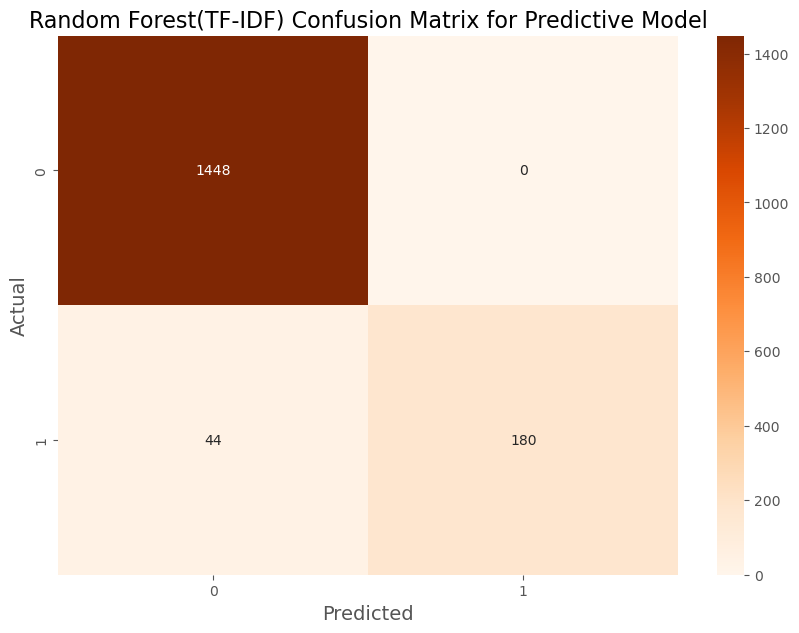

0.9736842105263158

In [8]:
cm = confusion_matrix(y_test, y_pred)


# Plotting
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True,cmap='Oranges', fmt='g')
plt.title('Random Forest(TF-IDF) Confusion Matrix for Predictive Model', fontsize=16)
plt.ylabel('Actual', fontsize=14)
plt.xlabel('Predicted', fontsize=14)
plt.show()
accuracy_score(y_test, y_pred)

In [54]:
n_estimators_range = range(1, 151) 
scores = []
for n_estimators in n_estimators_range:
    model = RandomForestClassifier(n_estimators = n_estimators, criterion = 'entropy',random_state=1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    scores.append(score)

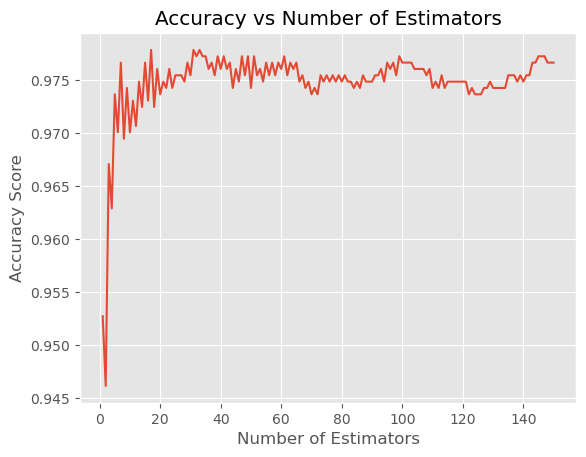

In [55]:
plt.plot(n_estimators_range, scores)
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy Score')
plt.title('Accuracy vs Number of Estimators')
plt.show()

In [ ]:
parameter = {'n_estimators': range(5, 41)}
model = RandomForestClassifier(criterion='entropy', random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=parameter, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_n_estimators = grid_search.best_estimator_.get_params()['n_estimators']
print(f"The best number of estimators is: {best_n_estimators}")
#The best number ofestimators is 37

## Modeling: Random Forest (Word2Vec)

In [46]:
X = X_word2vec
y = df['Label'].apply(lambda x: 1 if x == 'spam' else 0) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)


X_res, y_res = SMOTE(random_state=1).fit_resample(X_train, y_train)

rf_classifierW2V = RandomForestClassifier(n_estimators=47, criterion = 'entropy', random_state=1) 
#rf_classifierW2V.fit(X_train, y_train)
rf_classifierW2V.fit(X_res, y_res)

y_pred = rf_classifierW2V.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC :", roc_auc_score(y_test, y_pred))
#estimators = 100 => 94.85%
#estimators = 47  => 95.16%

Accuracy: 0.9560538116591928

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97       966
           1       0.89      0.77      0.82       149

    accuracy                           0.96      1115
   macro avg       0.93      0.88      0.90      1115
weighted avg       0.95      0.96      0.95      1115

ROC : 0.8753039587588757


In [ ]:
n_estimators_range = range(1, 151) 
scores = []
for n_estimators in n_estimators_range:
    model = RandomForestClassifier(n_estimators = n_estimators, criterion = 'entropy',random_state=1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    scores.append(score)

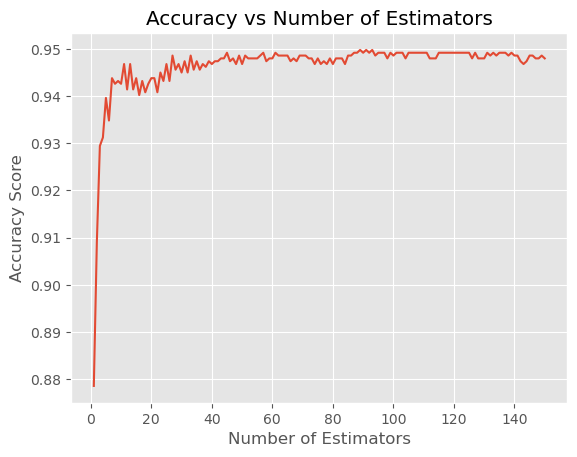

In [17]:
plt.plot(n_estimators_range, scores)
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy Score')
plt.title('Accuracy vs Number of Estimators')
plt.show()

In [18]:

parameter = {'n_estimators': range(20, 50)}
model = RandomForestClassifier(criterion='entropy', random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=parameter, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_n_estimators = grid_search.best_estimator_.get_params()['n_estimators']
print(f"The best number of estimators is: {best_n_estimators}")
#The best number of estimators is: 47

The best number of estimators is: 47


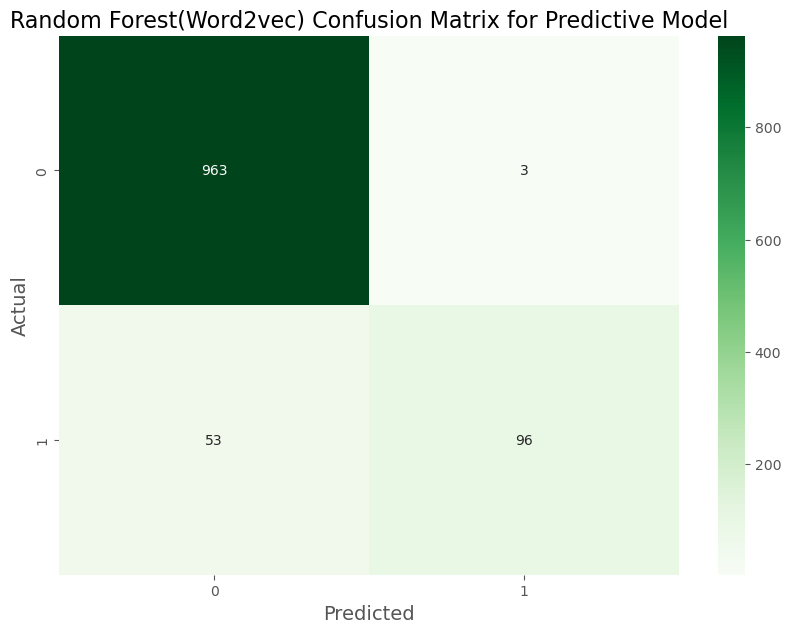

0.9497757847533632

In [13]:
cm = confusion_matrix(y_test, y_pred)


# Plotting


plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True,cmap='Greens', fmt='g')
plt.title('Random Forest(Word2vec) Confusion Matrix for Predictive Model', fontsize=16)
plt.ylabel('Actual', fontsize=14)
plt.xlabel('Predicted', fontsize=14)
plt.show()
accuracy_score(y_test, y_pred)

## CNN

In [14]:

X_tfidf_reshaped = np.expand_dims(X_tfidf, axis=2) 

print("Reshaped TF-IDF shape:", X_tfidf_reshaped.shape)

#class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
#class_weight_dict = dict(enumerate(class_weights))

modelCNNTF = Sequential()
modelCNNTF.add(Conv1D(128, 5, activation='relu', input_shape=(X_tfidf_reshaped.shape[1], 1))) #
modelCNNTF.add(GlobalMaxPooling1D())
modelCNNTF.add(Dense(10, activation='relu'))
modelCNNTF.add(Dense(1, activation='sigmoid'))

modelCNNTF.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.3, random_state=1, stratify=y)
X_res, y_res = SMOTE(random_state=1).fit_resample(X_train, y_train)
X_res, y_res = TomekLinks().fit_resample(X_res, y_res)

modelCNNTF.fit(X_res, y_res, epochs=5, batch_size=64, validation_data=(X_test, y_test))#, class_weight=class_weight_dict

results = modelCNNTF.evaluate(X_test, y_test)
print("Test Loss, Test Accuracy:", results)


Reshaped TF-IDF shape: (5572, 5000, 1)
Epoch 1/5
106/106 [==============================] - 11s 99ms/step - loss: 0.6335 - accuracy: 0.6387 - val_loss: 0.4766 - val_accuracy: 0.8648
Epoch 2/5
106/106 [==============================] - 11s 103ms/step - loss: 0.5280 - accuracy: 0.7825 - val_loss: 0.4989 - val_accuracy: 0.7201
Epoch 3/5
106/106 [==============================] - 10s 98ms/step - loss: 0.4676 - accuracy: 0.7821 - val_loss: 0.4592 - val_accuracy: 0.7500
Epoch 4/5
106/106 [==============================] - 10s 96ms/step - loss: 0.4532 - accuracy: 0.7849 - val_loss: 0.5096 - val_accuracy: 0.7111
Epoch 5/5
53/53 [==============================] - 1s 9ms/step - loss: 0.5176 - accuracy: 0.7093
Test Loss, Test Accuracy: [0.5176205039024353, 0.709330141544342]


53/53 [==============================] - 1s 11ms/step


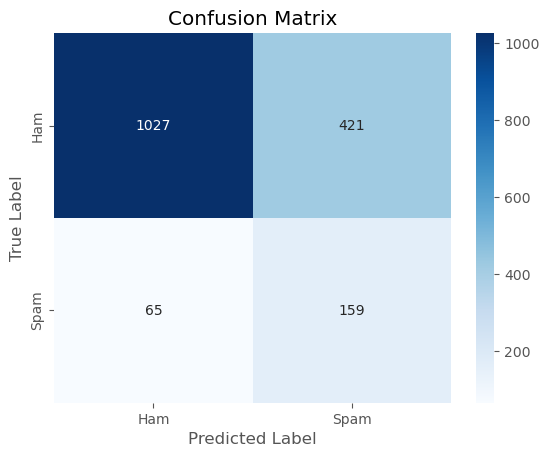

In [15]:
y_pred_prob = modelCNNTF.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [10]:
X_word2vec_reshaped = np.expand_dims(X_word2vec, axis=2)
#class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
#class_weight_dict = dict(enumerate(class_weights))

modelCNNW2V = Sequential()
modelCNNW2V.add(Conv1D(128, 5, activation='relu', input_shape=(X_word2vec_reshaped.shape[1], 1)))
modelCNNW2V.add(BatchNormalization())
modelCNNW2V.add(GlobalMaxPooling1D())
modelCNNW2V.add(Dropout(0.2))
modelCNNW2V.add(Dense(10, activation='relu'))
modelCNNW2V.add(Dense(1, activation='sigmoid'))
modelCNNW2V.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


X_train, X_test, y_train, y_test = train_test_split(X_word2vec, y, test_size=0.2, random_state=1, stratify=y)

X_res, y_res = SMOTE(random_state=1).fit_resample(X_train, y_train)
X_res, y_res = TomekLinks().fit_resample(X_res, y_res)

modelCNNW2V.fit(X_res, y_res, epochs=20, batch_size=64, validation_data=(X_test, y_test))#, class_weight=class_weight_dict


results = modelCNNW2V.evaluate(X_test, y_test)
print("Test Loss, Test Accuracy:", results)




Epoch 1/20


121/121 [==============================] - 2s 6ms/step - loss: 0.6963 - accuracy: 0.5424 - val_loss: 0.6713 - val_accuracy: 0.5238
Epoch 2/20
121/121 [==============================] - 1s 5ms/step - loss: 0.6650 - accuracy: 0.5807 - val_loss: 0.6601 - val_accuracy: 0.4637
Epoch 3/20
121/121 [==============================] - 1s 5ms/step - loss: 0.6580 - accuracy: 0.5872 - val_loss: 0.6909 - val_accuracy: 0.3175
Epoch 4/20
121/121 [==============================] - 1s 5ms/step - loss: 0.6549 - accuracy: 0.5870 - val_loss: 0.6899 - val_accuracy: 0.3211
Epoch 5/20
121/121 [==============================] - 1s 5ms/step - loss: 0.6527 - accuracy: 0.5886 - val_loss: 0.6925 - val_accuracy: 0.3058
Epoch 6/20
121/121 [==============================] - 1s 5ms/step - loss: 0.6525 - accuracy: 0.5890 - val_loss: 0.6657 - val_accuracy: 0.3857
Epoch 7/20
121/121 [==============================] - 1s 5ms/step - loss: 0.6510 - accuracy: 0.5907 - val_loss: 0.6319 - val_accuracy: 0.4556
Ep

35/35 [==============================] - 0s 1ms/step


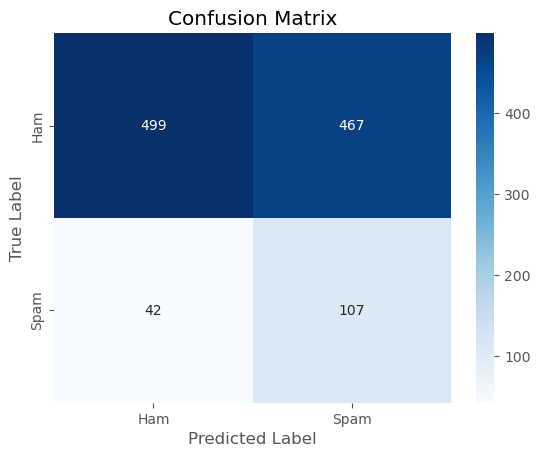

In [11]:
y_pred_prob = modelCNNW2V.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


## SPAM Generation

In [20]:
spam_msg = df[df['Label'] == 'spam']['Message']
spam_msg = spam_msg.apply(lambda x: x.lower().translate(str.maketrans('', '', string.punctuation)))


In [21]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(spam_msg)
sequences = tokenizer.texts_to_sequences(spam_msg)
seq_length = 10

train_sequences = []
for sequence in sequences:
    for i in range(seq_length, len(sequence)):
        train_sequences.append(sequence[i-seq_length:i+1])

train_sequences = pad_sequences(train_sequences, maxlen=seq_length+1, padding='pre')
train_sequences = np.array(train_sequences)
X, y = train_sequences[:, :-1], train_sequences[:, -1]
y = to_categorical(y, num_classes=len(tokenizer.word_index)+1)
#


In [22]:
Vsize = len(tokenizer.word_index) + 1

modelSPAM = Sequential()
modelSPAM.add(Embedding(Vsize, 50, input_length=seq_length))
modelSPAM.add(LSTM(150, return_sequences=True))
modelSPAM.add(LSTM(150))
modelSPAM.add(Dense(150, activation='relu'))
modelSPAM.add(Dense(Vsize, activation='softmax'))

modelSPAM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
modelSPAM.fit(X, y, batch_size=64, epochs=100)

Epoch 1/100
83/83 [==============================] - 4s 15ms/step - loss: 7.3409 - accuracy: 0.0236
Epoch 2/100
83/83 [==============================] - 1s 15ms/step - loss: 6.7057 - accuracy: 0.0332
Epoch 3/100
83/83 [==============================] - 1s 17ms/step - loss: 6.5531 - accuracy: 0.0307
Epoch 4/100
83/83 [==============================] - 1s 16ms/step - loss: 6.4422 - accuracy: 0.0328
Epoch 5/100
83/83 [==============================] - 1s 16ms/step - loss: 6.2544 - accuracy: 0.0355
Epoch 6/100
83/83 [==============================] - 1s 15ms/step - loss: 6.1008 - accuracy: 0.0353
Epoch 7/100
83/83 [==============================] - 1s 16ms/step - loss: 5.9351 - accuracy: 0.0387
Epoch 8/100
83/83 [==============================] - 1s 16ms/step - loss: 5.7679 - accuracy: 0.0417
Epoch 9/100
83/83 [==============================] - 1s 17ms/step - loss: 5.5511 - accuracy: 0.0504
Epoch 10/100
83/83 [==============================] - 1s 18ms/step - loss: 5.2777 - accuracy: 0.0606

In [25]:
def generate_text(modelSPAM, tokenizer, seq_length, seed_text, num_gen_words):
    output_text = []
    input_text = seed_text
    for _ in range(num_gen_words):
        encoded = tokenizer.texts_to_sequences([input_text])[0]
        encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
        
        predictions = modelSPAM.predict(encoded, verbose=0)
        pred_word_index = np.argmax(predictions, axis=-1)[0]
        pred_word = tokenizer.index_word.get(pred_word_index, '')
        
        input_text += ' ' + pred_word
        output_text.append(pred_word)
    
    return ' '.join(output_text)

generated_texts = []
seed_texts = [
    "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005.",
    "URGENT! You have won a 1 week FREE membership in our £100,000 Prize Jackpot!",
    "England v Macedonia - dont miss the goals/team news. Txt ur national team to 87077 eg ENGLAND to 87077 Try:WALES, SCOTLAND 4txt/ú1.20 POBOXox36504W45WQ 16+",
    "Thanks for your subscription to Ringtone UK your mobile will be charged £5/month Please confirm by replying YES or NO. If you reply NO you will not be charged",
    "SMS. ac Sptv: The New Jersey Devils and the Detroit Red Wings play Ice Hockey. Correct or Incorrect? End? Reply END SPTV",
    "Congrats! 1 year special cinema pass for 2 is yours. call 09061209465 now! C Suprman V, Matrix3, StarWars3, etc all 4 FREE! bx420-ip4-5we. 150pm. Dont miss out! ",
    "You are a winner U have been specially selected 2 receive £1000 or a 4* holiday (flights inc) speak to a live operator 2 claim 0871277810910p/min (18+) ",
    "URGENT! Your Mobile No. was awarded £2000 Bonus Caller Prize on 5/9/03 This is our final try to contact U! Call from Landline 09064019788 BOX42WR29C, 150PPM",
    "Sunshine Quiz Wkly Q! Win a top Sony DVD player if u know which country the Algarve is in? Txt ansr to 82277. £1.50 SP:Tyrone",
    "Customer service annoncement. You have a New Years delivery waiting for you. Please call 07046744435 now to arrange delivery"
    ]
for seed in seed_texts:
    new_text = generate_text(modelSPAM, tokenizer, seq_length, seed, 20)  
    generated_texts.append(new_text)
while len(generated_texts) < 100:
    for seed in seed_texts:
        new_text = generate_text(modelSPAM, tokenizer, seq_length, seed, 20)
        generated_texts.append(new_text)
        if len(generated_texts) >= 100:
            break

print("Total generated texts:", len(generated_texts))
print(generated_texts[:30])  


Total generated texts: 100
['text fa 87121 receive entry questionstd txt ratetcs apply 08452810075over18s calls£1minmobsmorelkpobox177hp51fl swap www80488biz med landline tc 021 6hl removal stop', 'end guaranteed call 80122300pwk services 290305 else gbp5month transferred someone claim transferred leadership ref9307622 skills 09050002311 e register saturday pobox', 'pobox36504w45wq 18 reply 4 free 2 £100 camcorder free rental call 08000930705 delivery tomorrow collection free sae tcs stockport sk38xh', '18 charges 2 award 150p call choice arrange soundtrack cash operator 2 camcorder 150ppm call 08000930705 delivery tomorrow toclaim sae', 'sptv next £150ea otbox 731 mmsto pass maniac reschedule £250 min give lotr services moby duchess 69888 07821230901 else cust', 'stop texts reply call 08719180248 £150 games pocketbabecouk 09064019788 box42wr29c 150ppm stop apply 18 opt reply call customer identifier code4xx26', '18 150 cs mobile wk 150 sexy stop girls send extra free tone cancel cs 08

## SPAM testing

In [27]:
## preprocess
def preprocess(new_text):
    new_text = new_text.lower()
    new_text = new_text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(new_text)

    stop = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop]

    new_text = ' '.join(tokens)
    return new_text

processed_texts = [preprocess(text) for text in generated_texts]

print(processed_texts[:5])

['text fa 87121 receive entry questionstd txt ratetcs apply 08452810075over18s calls£1minmobsmorelkpobox177hp51fl swap www80488biz med landline tc 021 6hl removal stop', 'end guaranteed call 80122300pwk services 290305 else gbp5month transferred someone claim transferred leadership ref9307622 skills 09050002311 e register saturday pobox', 'pobox36504w45wq 18 reply 4 free 2 £100 camcorder free rental call 08000930705 delivery tomorrow collection free sae tcs stockport sk38xh', '18 charges 2 award 150p call choice arrange soundtrack cash operator 2 camcorder 150ppm call 08000930705 delivery tomorrow toclaim sae', 'sptv next £150ea otbox 731 mmsto pass maniac reschedule £250 min give lotr services moby duchess 69888 07821230901 else cust']


In [28]:
def vectorize_text(text, model):
    words = text.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    else:
        return np.mean(word_vectors, axis=0)

processed_texts_word2vec = np.array([vectorize_text(text, word2vec_model) for text in processed_texts])
processed_texts_tfidf = tfidf_vectorizer.transform(processed_texts)

In [69]:
RF_pred_tfidf = rf_classifierTF.predict(processed_texts_tfidf)

true_labels = [1] * len(processed_texts)
print(classification_report(true_labels, RF_pred_tfidf))
print("Accuracy:", accuracy_score(true_labels, RF_pred_tfidf))


              precision    recall  f1-score   support

           1       1.00      1.00      1.00       100

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

Accuracy: 1.0


In [70]:
true_labels = [1] * len(processed_texts)
RF_pred_word2vec = rf_classifierW2V.predict(processed_texts_word2vec)
print(classification_report(true_labels, RF_pred_word2vec))
print("Accuracy:", accuracy_score(true_labels, RF_pred_word2vec))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.80      0.89       100

    accuracy                           0.80       100
   macro avg       0.50      0.40      0.44       100
weighted avg       1.00      0.80      0.89       100

Accuracy: 0.8


In [30]:
true_labels = [1] * len(processed_texts)
processed_texts_tfidf_reshaped = np.expand_dims(processed_texts_tfidf.toarray(), axis=2)
predicted_labels = modelCNNTF.predict(processed_texts_tfidf_reshaped)
predicted_labels = (predicted_labels > 0.5).astype(int).flatten()
#hard time

print(classification_report(true_labels, predicted_labels))
print("Accuracy:", accuracy_score(true_labels, predicted_labels))

4/4 [==============================] - 0s 9ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.70      0.82       100

    accuracy                           0.70       100
   macro avg       0.50      0.35      0.41       100
weighted avg       1.00      0.70      0.82       100

Accuracy: 0.7


In [31]:
processed_texts_word2vec_reshaped = np.expand_dims(processed_texts_word2vec, axis=2)
predicted_labels = modelCNNW2V.predict(processed_texts_word2vec_reshaped)
predicted_labels = (predicted_labels > 0.5).astype(int).flatten()
print(classification_report(true_labels, predicted_labels))
print("Accuracy:", accuracy_score(true_labels, predicted_labels))

4/4 [==============================] - 0s 14ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.70      0.82       100

    accuracy                           0.70       100
   macro avg       0.50      0.35      0.41       100
weighted avg       1.00      0.70      0.82       100

Accuracy: 0.7
